# Make the Best Model for the mood of the song

In this document I will studie the stream and position columns. 

Best model = also looking at country, number of streams and position (other notebook for time on top list)<BR />

I will have to repeat a few steps from the previous notebooks to get it to the right startingpoint. 

Then when we have the best model we can use our predictions and decide the mood of a country and the mood of an artist. Then we can say what artist is suitable for what country. 

## Import stuff

In [25]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-bright')

%matplotlib inline

## Load data

In [26]:
data = pd.read_csv('./data_top10c_more_lyrics.csv')
data.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756


## Fix a little bit with the data

#### Get dummies for the Country column

In [27]:
country_dum = pd.get_dummies(data['Country'])
country_dum.head(3)

,au,ca,de,fr,gb,it,nl,us
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0


In [28]:
data_c = pd.concat([data, country_dum], axis=1)
data_c.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,...,Tempo,Valence,au,ca,de,fr,gb,it,nl,us
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,...,172.656,0.879,0,0,0,0,1,0,0,0
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,...,105.003,0.756,0,0,0,0,0,1,0,0
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,...,105.003,0.756,0,0,0,0,0,1,0,0


#### Get dummies for the Position column

In [29]:
position_dum = pd.get_dummies(data['Position'])
position_dum.head(3)

,1,2,3,4,5,6,7,8,9,10,...,191,192,193,194,195,196,197,198,199,200
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
data_c_p = pd.concat([data_c, position_dum], axis=1)
data_c_p.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,...,191,192,193,194,195,196,197,198,199,200
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,...,0,0,0,0,0,0,0,0,0,0
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,...,0,0,0,0,0,0,0,0,0,0
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,...,0,0,0,0,0,0,0,0,0,0


#### Group by ID, sum()

In [31]:
data_cp_groupbyID = data_c_p.groupby('ID').sum()
data_cp_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,...,191,192,193,194,195,196,197,198,199,200
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,...,5.0,5.0,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Work with the Streams column

In [32]:
len(data_cp_groupbyID)

8223

In [33]:
data_cp_groupbyID['avg_Streams'] = data_cp_groupbyID['Streams']/len(data_cp_groupbyID)
data_cp_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,...,192,193,194,195,196,197,198,199,200,avg_Streams
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,...,5.0,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707


#### Work more with the Position column

In [34]:
len(data_cp_groupbyID)

8223

In [35]:
data_cp_groupbyID['avg_Position'] = data_cp_groupbyID['Position']/len(data_cp_groupbyID)
data_cp_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,...,193,194,195,196,197,198,199,200,avg_Streams,avg_Position
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,...,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917,10.340873
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166,0.068466
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707,0.014715


#### Drop columns that make no sense after the group by or that I do not need

In [36]:
data_cps = data_cp_groupbyID.drop(['Unnamed: 0', 'Position', 'Streams', 'Year', 'Month', 'Day', 'Acousticness',
                        'Energy', 'Instrumentalness', 'Mode', 'Tempo', 'Valence'], axis=1)
data_cps.head(3)

,au,ca,de,fr,gb,it,nl,us,1,2,...,193,194,195,196,197,198,199,200,avg_Streams,avg_Position
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,0.0,0.0,...,3.0,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917,10.340873
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166,0.068466
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707,0.014715


In [37]:
# make a new column for ID so that I can merge on ID later
data_cps['ID'] = data_cps.index
data_cps.head(3)

,au,ca,de,fr,gb,it,nl,us,1,2,...,194,195,196,197,198,199,200,avg_Streams,avg_Position,ID
ID,,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,0.0,0.0,...,2.0,2.0,8.0,0.0,5.0,3.0,3.0,7655.159917,10.340873,000xQL6tZNLJzIrtIgxqSl
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,28.384166,0.068466,007d7JT41sSc1HqWTs4uw7
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.521707,0.014715,00BuKLSAFkaEkaVAgIMbeA


#### Drop rows that are duplicates and keep only one row for each song (based on ID)

In [38]:
data_per_song = data.drop_duplicates(subset=['ID'], keep='first')
data_per_song.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560
43,43,147,43037,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,2017-12-24,2017,12,24,fr,eu,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498


#### Drop all columns that might change per song

In [39]:
data_per_song = data_per_song.drop(['Unnamed: 0', 'Position', 'Streams', 'Date', 'Year', 'Month', 'Day', 'Country',
                                   'Region'], axis=1)
data_per_song.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560
43,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498


#### Combine the 2 data frames with columns that may and may not change per song

In [40]:
big_df_song = data_per_song.merge(data_cps, how='inner', on='ID')
big_df_song.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,193,194,195,196,197,198,199,200,avg_Streams,avg_Position
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.910738,0.021525
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,483.813207,0.627873
2,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.233735,0.017877


#### Drop rows that have missing values in the Lyrics column <BR />
We can use dropna to drop all rows that has missing values (should mostly be the Lyrics column)

In [41]:
len(big_df_song)

8223

In [42]:
big_df_song = big_df_song.dropna(axis=0, how='any')

In [43]:
len(big_df_song)

4995

### TextBlob

#### Turn the lyrics in the Lyrics column into string

In [44]:
big_df_song['Lyrics'] = big_df_song['Lyrics'].astype(str)

#### Make and run function for TextBlob on the Lyrics

In [45]:
def sentiment_func(lyrics):
    try:
        return TextBlob(lyrics).sentiment
    except:
        return None

In [46]:
big_df_song['pol_sub'] = big_df_song['Lyrics'].apply(sentiment_func)

#### Split the pol_sub column into 2 new columns (Polarity, Subjectivity)

In [47]:
big_df_song['Polarity'] = big_df_song['pol_sub'].apply(lambda x: x[0])
big_df_song['Subjectivity'] = big_df_song['pol_sub'].apply(lambda x: x[1])

#### Drop the pol_sub column

In [48]:
big_df_song = big_df_song.drop(['pol_sub'], axis=1)

### Do a quick check of the entire data frame

In [49]:
big_df_song.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,195,196,197,198,199,200,avg_Streams,avg_Position,Polarity,Subjectivity
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879,...,0.0,0.0,0.0,0.0,0.0,0.0,4.910738,0.021525,-0.044455,0.590802
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756,...,0.0,0.0,1.0,0.0,0.0,0.0,483.813207,0.627873,0.583150,0.670696
5,Somme,13 Block,2xkxBVJHf9jQsq7g46UtQx,"J'ai fait l'aller, j'suis sur le retour\nLa ma...",0.4940,0.678,0.00151,0.0,79.979,0.528,...,0.0,1.0,0.0,0.0,0.0,0.0,4.951356,0.046820,0.173810,0.541667


In [50]:
big_df_song.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4995 entries, 0 to 8222
Columns: 222 entries, Track Name to Subjectivity
dtypes: float64(218), object(4)
memory usage: 8.5+ MB


#### Save data to csv

In [51]:
# load the data to a .csv
big_df_song.to_csv('big_df_song20180401.csv')

## Train/test split

Divide the data into a train and a test set (with default size: train/test split size -> 0.75/0.25)

In [52]:
big_df_dep   = big_df_song['Valence']
big_df_indep = big_df_song
indep_train, indep_test, dep_train, dep_test = train_test_split(big_df_indep, big_df_dep, random_state=24)

In [53]:
indep_train.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,195,196,197,198,199,200,avg_Streams,avg_Position,Polarity,Subjectivity
4697,In the Name of Love,Lorenzo Licitra,22f8oNe0PKMgWyO5YANK0N,Can you still see the dreams we shared so long...,0.219,0.783,0.0,1.0,124.028,0.205,...,0.0,0.0,0.0,0.0,0.0,0.0,62.547124,0.263894,0.388509,0.527640
1821,Avant,Djadja & Dinaz,18ZQtwHl6ni4lZyocy6Ohr,C'est Dieu qui donne ma gueule\nC'est lui qui ...,0.107,0.535,0.0,0.0,143.962,0.331,...,1.0,0.0,1.0,0.0,0.0,0.0,70.955004,0.336982,0.025000,0.400000
6563,Yours,Russell Dickerson,6RSNKGdv3nDTHqgw4bdzyF,i was a boat stuck in a bottle that never got ...,0.119,0.722,0.0,1.0,134.058,0.559,...,0.0,0.0,2.0,1.0,3.0,0.0,275.692934,0.273501,0.234936,0.473825


## NLP

In [54]:
# read in csv with stop words
stop_words_df = pd.read_csv('./stop_words.csv')

In [55]:
# turn the df to list
stop_words = stop_words_df['colummn'].tolist()

### CountVectorizer (use in model 1)

In [56]:
# instantiate the model (stop-words the list of 4 languages and max top features 500)
cvec = CountVectorizer(stop_words = stop_words, max_features = 500)

**Train**

In [57]:
# fit the count vectorizer with training data. 
cvec.fit(indep_train['Lyrics'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...s', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [58]:
# transform X_train
cvec_data = cvec.transform(indep_train['Lyrics'])

In [59]:
# Turn the features into a data frame
df  = pd.DataFrame(cvec_data.todense(),columns=cvec.get_feature_names())

In [60]:
len(indep_train)

3746

In [61]:
len(df)

3746

In [62]:
# Concat with big data frame (use for fitting the model)
indep_train_cvec = pd.concat([indep_train.reset_index(drop=True), df], axis=1)

indep_train_cvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,In the Name of Love,Lorenzo Licitra,22f8oNe0PKMgWyO5YANK0N,Can you still see the dreams we shared so long...,0.219,0.783,0.0,1.0,124.028,0.205,...,3,0,0,0,0,0,0,0,0,0
1,Avant,Djadja & Dinaz,18ZQtwHl6ni4lZyocy6Ohr,C'est Dieu qui donne ma gueule\nC'est lui qui ...,0.107,0.535,0.0,0.0,143.962,0.331,...,0,0,0,0,0,0,0,0,6,0
2,Yours,Russell Dickerson,6RSNKGdv3nDTHqgw4bdzyF,i was a boat stuck in a bottle that never got ...,0.119,0.722,0.0,1.0,134.058,0.559,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# look and see that the shape look right
len(indep_train_cvec)

3746

**Test**

In [64]:
# transform X_test
cvec_data2 = cvec.transform(indep_test['Lyrics'])

In [65]:
# Turn the features into a data frame
df2  = pd.DataFrame(cvec_data2.todense(),columns=cvec.get_feature_names())

In [66]:
len(indep_test)

1249

In [67]:
len(df2)

1249

In [68]:
# Concat with big data frame (use for scoring the model)
indep_test_cvec = pd.concat([indep_test.reset_index(drop=True), df2], axis=1)

indep_test_cvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,Vide,13 Block,69RclklKbEelwfQJCBzh0m,"13 Blo' gang, tu sais d'jà comment on opère mo...",0.5050,0.682,0.000006,0.0,112.063,0.514,...,0,0,0,0,0,0,0,0,1,0
1,Werken,Jonna Fraser,0qqzMM6JR2UlCyPanXRz3Y,"Het komt niet vanzelf, moest werken\nWe komen ...",0.0789,0.530,0.000025,0.0,133.903,0.288,...,0,6,3,0,2,0,1,1,0,0
2,Sweet Child O' Mine,Guns N' Roses,7o2CTH4ctstm8TNelqjb51,she's got a smile it seems to me reminds me of...,0.0801,0.911,0.146000,1.0,125.122,0.630,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# look and see that the shape look right
len(indep_test_cvec)

1249

In [70]:
# read to CSV
indep_train_cvec.to_csv('final_train_cvec.csv')
indep_test_cvec.to_csv('final_test_cvec.csv')

*If there are time in the future consider stemming or lemming* 

### TF-IDF (use in model 2)

In [71]:
# instantiate the model (stop-words the list of 4 languages and max top features 500)
tvec = TfidfVectorizer(stop_words = stop_words, max_features = 500) 

**Train**

In [72]:
# fit the count vectorizer with training data. 
tvec.fit(indep_train['Lyrics'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'ar...s', 'trabajais', 'trabajan', 'podria', 'podrias', 'podriamos', 'podrian', 'podriais', 'yo', 'aquel'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [73]:
# transform X_train
tvec_data = tvec.transform(indep_train['Lyrics'])

In [74]:
# Turn the features into a data frame
df3  = pd.DataFrame(tvec_data.todense(),columns=tvec.get_feature_names())

In [75]:
len(indep_train)

3746

In [76]:
len(df3)

3746

In [77]:
# Concat with big data frame (use for fitting the model)
indep_train_tvec= pd.concat([indep_train.reset_index(drop=True), df3], axis=1)

indep_train_tvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,In the Name of Love,Lorenzo Licitra,22f8oNe0PKMgWyO5YANK0N,Can you still see the dreams we shared so long...,0.219,0.783,0.0,1.0,124.028,0.205,...,0.204224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Avant,Djadja & Dinaz,18ZQtwHl6ni4lZyocy6Ohr,C'est Dieu qui donne ma gueule\nC'est lui qui ...,0.107,0.535,0.0,0.0,143.962,0.331,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.432343,0.0
2,Yours,Russell Dickerson,6RSNKGdv3nDTHqgw4bdzyF,i was a boat stuck in a bottle that never got ...,0.119,0.722,0.0,1.0,134.058,0.559,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [78]:
# look and see that the shape look right
len(indep_train_tvec)

3746

**Test**

In [79]:
# transform X_test
tvec_data4 = tvec.transform(indep_test['Lyrics'])

In [80]:
# Turn the features into a data frame
df4  = pd.DataFrame(tvec_data4.todense(),columns=tvec.get_feature_names())

In [81]:
len(indep_test)

1249

In [82]:
len(df4)

1249

In [83]:
# Concat with big data frame (use for scoring the model)
indep_test_tvec = pd.concat([indep_test.reset_index(drop=True), df4], axis=1)

indep_test_tvec.head(3)

,Track Name,Artist,ID,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,...,young,ze,zeg,zeit,zie,zieh,zijn,zo,étais,était
0,Vide,13 Block,69RclklKbEelwfQJCBzh0m,"13 Blo' gang, tu sais d'jà comment on opère mo...",0.5050,0.682,0.000006,0.0,112.063,0.514,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.025733,0.0
1,Werken,Jonna Fraser,0qqzMM6JR2UlCyPanXRz3Y,"Het komt niet vanzelf, moest werken\nWe komen ...",0.0789,0.530,0.000025,0.0,133.903,0.288,...,0.0,0.123725,0.073429,0.0,0.047735,0.0,0.021651,0.024126,0.000000,0.0
2,Sweet Child O' Mine,Guns N' Roses,7o2CTH4ctstm8TNelqjb51,she's got a smile it seems to me reminds me of...,0.0801,0.911,0.146000,1.0,125.122,0.630,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [84]:
# look and see that the shape look right
len(indep_test_tvec)

1249

In [85]:
# read to CSV
indep_train_tvec.to_csv('final_train_tvec.csv')
indep_test_tvec.to_csv('final_test_tvec.csv')

## Models (LinReg, Lasso, RF, Ada/Gradient Boost) - CountVec

### Linear Regression

In [188]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### LinReg #1 - CountVec + all coefs

In [189]:
# define X and y
X_train = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train = indep_train['Valence'] # the same as dep_train
X_test = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test = indep_test['Valence'] # the same as dep_test

# chose model 
linreg = LinearRegression()

# call function
evaluate_model(linreg, X_train, X_test, y_train, y_test)

{'MSE': 0.2179414544286909, 'Score (R^2)': 0.013486410677653882}

**Importance of the coefficients**

In [190]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train.columns,linreg.coef_))).abs().sort_values(ascending=False).head(10)

boo             0.093560
Energy          0.093037
peek            0.089913
23              0.049723
Acousticness    0.033129
2               0.031798
43              0.030468
14              0.029557
76              0.027777
27              0.027467
dtype: float64

#### LinReg #2 - CountrVec + top 10 coefs

In [63]:
# define X and y
X_train2 = indep_train_cvec[['boo', 'Energy', 'peek', 23, 'Acousticness', 2, 43, 14, 76, 27]]
y_train2 = indep_train['Valence']
X_test2 = indep_test_cvec[['boo', 'Energy', 'peek', 23, 'Acousticness', 2, 43, 14, 76, 27]]
y_test2 = indep_test['Valence']

# chose model 
linreg2 = LinearRegression()

# call function
evaluate_model(linreg2, X_train2, X_test2, y_train2, y_test2)

{'MSE': 0.2014625390102933, 'Score (R^2)': 0.15703025345048383}

#### LinReg #3 - CountrVec + top 3 coefs

In [64]:
# define X and y
X_train3 = indep_train_cvec[['boo', 'Energy', 'peek']]
y_train3 = indep_train['Valence']
X_test3 = indep_test_cvec[['boo', 'Energy', 'peek']]
y_test3 = indep_test['Valence']

# chose model 
linreg3 = LinearRegression()

# call function
evaluate_model(linreg3, X_train3, X_test3, y_train3, y_test3)

{'MSE': 0.20245127414703298, 'Score (R^2)': 0.14873571822331177}

*COMMENT: The best LinReg is nr 2*

### Lasso Regressor

In [65]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid) # cv default = 3
    
    # fit
    gs.fit(X_train_s, y_train)
     
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Lasso #1 - CountVec + all coefs**

In [66]:
# Declare indep and dep
X_train4 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train4 = dep_train
X_test4 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test4 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg, grid, X_train4, y_train4)

{'best_params': {'alpha': 0.005336699231206312, 'selection': 'random'},
 'best_score': 0.1679253962634286}

In [67]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0053, selection='random')

# call function
evaluate_model(lassoreg, X_train4, X_test4, y_train4, y_test4)

{'MSE': 0.19743399228941258, 'Score (R^2)': 0.19040608132068992}

In [68]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train4.columns,lassoreg.coef_))).abs().sort_values(ascending=False).head(15)

Energy          0.082268
Acousticness    0.021660
baby            0.014524
shit            0.007908
je              0.006439
vois            0.005920
ogni            0.005694
thing           0.005629
mich            0.005187
Mode            0.004763
quando          0.004670
girl            0.004613
niggas          0.004450
gonna           0.004327
kommt           0.004090
dtype: float64

#### Lasso #2 - CountVec + top 10 coefs

In [69]:
# Declare indep and dep
X_train5 = indep_train_cvec[['Energy', 'Acousticness', 'baby', 'shit', 'je', 'vois', 'ogni', 'thing', 'mich', 'Mode']]
y_train5 = dep_train
X_test5 = indep_test_cvec[['Energy', 'Acousticness', 'baby', 'shit', 'je', 'vois', 'ogni', 'thing', 'mich', 'Mode']]
y_test5= dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg2 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg2, grid, X_train5, y_train5)

{'best_params': {'alpha': 0.001, 'selection': 'random'},
 'best_score': 0.1727356149875209}

In [70]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg2 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='random')

# call function
evaluate_model(lassoreg2, X_train5, X_test5, y_train5, y_test5)

{'MSE': 0.19905943437873008, 'Score (R^2)': 0.1770206960698385}

#### Lasso #3 - CountVec + top 3 coefs

In [71]:
# Declare indep and dep
X_train6 = indep_train_cvec[['Energy', 'Acousticness', 'baby']]
y_train6 = dep_train
X_test6 = indep_test_cvec[['Energy', 'Acousticness', 'baby']]
y_test6 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg3 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg3, grid, X_train6, y_train6)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.1523656182790846}

In [72]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg3 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg3, X_train6, X_test6, y_train6, y_test6)

{'MSE': 0.20021396415554327, 'Score (R^2)': 0.1674465753925105}

COMMENT: The best Lasso is nr 1

### Random Forest Regressor

You do not have to scale a Random Forest.

In [86]:
def get_best_hype(model, params, X_train, y_train):  
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=40)
    
    # fit
    rs.fit(X_train, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### Random Forest #1 - CountVec + all coefs

In [87]:
# Declare indep and dep
X_train7 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train7 = indep_train['Valence']
X_test7 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test7 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr = RandomForestRegressor(random_state=24)

get_best_hype(rfr, params, X_train7, y_train7)

{'best_params': {'bootstrap': True,
  'max_depth': 14,
  'max_features': 'auto',
  'n_estimators': 20,
  'verbose': 0},
 'best_score': 0.19411957098707736}

In [88]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr = RandomForestRegressor(max_depth=14, max_features='auto', n_estimators=20, verbose=0, bootstrap=True, 
                            random_state=24)

# call function
evaluate_model(rfr, X_train7, X_test7, y_train7, y_test7)

{'MSE': 0.19394911431322795, 'Score (R^2)': 0.21873389350372074}

In [ ]:
# I had to rerun the T/T-split and RF #1, therefor other R2-Score than recorded. 

**Feature importance**

In [89]:
pd.Series(dict(zip(X_train7.columns,rfr.feature_importances_))).abs().sort_values(ascending=False).head(15)

Energy              0.215756
Acousticness        0.054748
Tempo               0.025278
Instrumentalness    0.023027
Polarity            0.019044
Subjectivity        0.017454
avg_Position        0.016467
baby                0.016126
avg_Streams         0.011499
oh                  0.008947
girl                0.007467
je                  0.007416
like                0.005665
rien                0.005312
gb                  0.005051
dtype: float64

In [ ]:
# plot with feature importance

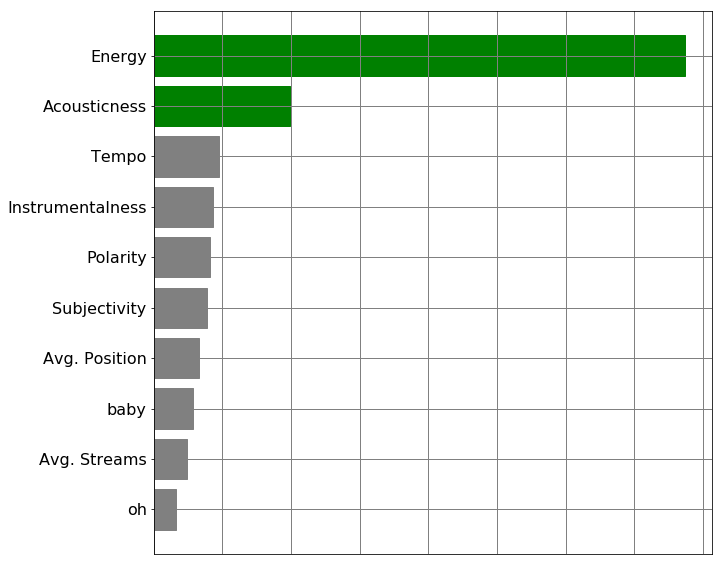

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

col = ('Energy', 'Acousticness', 'Tempo', 'Instrumentalness', 'Polarity', 'Subjectivity',
        'Avg. Position','baby' , 'Avg. Streams', 'oh')
y_pos = np.arange(len(col))
coeff = [0.193497, 0.049748, 0.023688, 0.021471, 0.020479, 0.019246, 0.016446, 0.014393, 0.012178, 0.007939]

barlist = ax.barh(y_pos, coeff, align='center')
barlist[0].set_color('green')
barlist[1].set_color('green')
barlist[2].set_color('gray')
barlist[3].set_color('gray')
barlist[4].set_color('gray')
barlist[5].set_color('gray')
barlist[6].set_color('gray')
barlist[7].set_color('gray')
barlist[8].set_color('gray')
barlist[9].set_color('gray')

plt.yticks(y_pos, col)
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
#plt.ylabel('Feature')
#plt.xlabel('Importance')
#plt.title('Feature Importance')
ax.invert_yaxis() 

plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=12)   
plt.rc('figure', titlesize=12)  
 
plt.grid()
ax.grid(color='grey', linestyle='-', linewidth=1)    

plt.show()

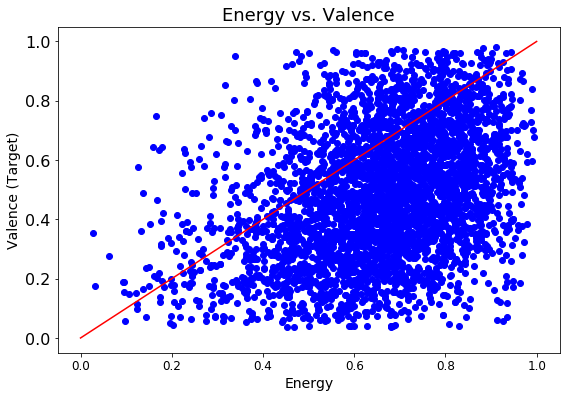

In [93]:
plt.figure(figsize=(9,6))
plt.scatter(indep_train_cvec['Energy'], indep_train_cvec['Valence'], color='blue')
plt.plot([0,1],[0,1], c='r')
plt.title('Energy vs. Valence', fontsize=18)
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Valence (Target)', fontsize=14);

#### Random Forest #2 - CountVec + top 10 features

In [131]:
# define X and y
X_train8 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo', 'Instrumentalness', 'Polarity', 'Subjectivity',
                             'avg_Position','baby' , 'avg_Streams', 'oh']]
y_train8 = indep_train['Valence']
X_test8 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo', 'Instrumentalness', 'Polarity', 'Subjectivity',
                            'avg_Position','baby' , 'avg_Streams', 'oh']]
y_test8 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr2 = RandomForestRegressor(random_state=24)

get_best_hype(rfr2, params, X_train8, y_train8)

{'best_params': {'bootstrap': True,
  'max_depth': 14,
  'max_features': 'sqrt',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.17268575928751276}

In [132]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr2 = RandomForestRegressor(max_depth=14, max_features='sqrt', n_estimators=90, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr2, X_train8, X_test8, y_train8, y_test8)

{'MSE': 0.19444088066811846, 'Score (R^2)': 0.2147670028572991}

#### Random Forest #3 - CountVec + top 3 features

In [133]:
# define X and y
X_train9 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo']]
y_train9 = indep_train['Valence']
X_test9 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo']]
y_test9 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr3 = RandomForestRegressor(random_state=24)

get_best_hype(rfr3, params, X_train9, y_train9)

{'best_params': {'bootstrap': True,
  'max_depth': 8,
  'max_features': 'log2',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.1362282574893324}

In [134]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr3 = RandomForestRegressor(max_depth=8, max_features='log2', n_estimators=50, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr3, X_train9, X_test9, y_train9, y_test9)

{'MSE': 0.20064355865025515, 'Score (R^2)': 0.1638699609332285}

COMMENT: The best RFr is nr 1

### Ada and Gradient Boost

In [135]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
     
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=27)
    
    # fit
    rs.fit(X_train_s, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Ada #1 - CountVec + all coefs**

In [82]:
# Declare indep and dep
X_train10 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train10 = indep_train['Valence']
X_test10 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test10 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('linear', 'square', 'exponential')}

ada = AdaBoostRegressor(random_state=24) 
# base_estimator = DecisionTreeRegressor() (default)
# learning_rate: (default=1.0)

get_best_hype(ada, params, X_train10, y_train10)

{'best_params': {'loss': 'linear', 'n_estimators': 10},
 'best_score': 0.1386397595627309}

In [83]:
# chose model and use best hyperparameters (from gridsearchCV)
ada = AdaBoostRegressor(n_estimators=10, loss='linear', random_state=24)
# I'm going with the default base_estimator, bc to choose a rfr is taking too long time

# call function
evaluate_model(ada, X_train10, X_test10, y_train10, y_test10)

{'MSE': 0.20054058276262823, 'Score (R^2)': 0.1647279913503793}

**Gradient #1 - CountVec + all coefs**

In [136]:
# Declare indep and dep
X_train11 = indep_train_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train11 = indep_train['Valence']
X_test11 = indep_test_cvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test11 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}


grad = GradientBoostingRegressor(random_state=24) 
# learning_rate: (default=1.0)
# init = BaseEstimator, default = None (loss.init_estimator)

get_best_hype(grad, params, X_train11, y_train11)

{'best_params': {'loss': 'lad',
  'max_depth': 14,
  'max_features': 'auto',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.19962339968927545}

In [137]:
# chose model and use best hyperparameters (from gridsearchCV)
grad = GradientBoostingRegressor(random_state=24, n_estimators=90, loss='lad', max_depth=14 , max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad, X_train11, X_test11, y_train11, y_test11)

{'MSE': 0.19148965797661502, 'Score (R^2)': 0.2384226323540044}

In [138]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train11.columns,grad.feature_importances_ ))).abs().sort_values(ascending=False).head(15)

Energy              0.037720
Acousticness        0.033737
Tempo               0.021022
Polarity            0.020520
Subjectivity        0.016390
avg_Streams         0.015298
avg_Position        0.015183
Instrumentalness    0.013482
oh                  0.006403
baby                0.006294
gb                  0.006031
yeah                0.006028
let                 0.005261
like                0.004988
want                0.004830
dtype: float64

**Gradient #2 - CountVec + top 10 coefs**

In [139]:
# define X and y
X_train12 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo', 'Polarity', 'Subjectivity','avg_Streams', 
                              'avg_Position', 'Instrumentalness', 'oh', 'baby']]
y_train12 = indep_train['Valence']
X_test12 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo', 'Polarity', 'Subjectivity','avg_Streams', 
                              'avg_Position', 'Instrumentalness', 'oh', 'baby']]
y_test12 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad2 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad2, params, X_train12, y_train12)

{'best_params': {'loss': 'ls',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 90,
  'verbose': 0},
 'best_score': 0.15764399822326167}

In [140]:
# chose model and use best hyperparameters (from gridsearchCV)
grad2 = GradientBoostingRegressor(random_state=24, n_estimators=90, loss='ls', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad2, X_train12, X_test12, y_train12, y_test12)

{'MSE': 0.19896438359756616, 'Score (R^2)': 0.17780645284450913}

**Gradient #3 - CountVec + top 3 coefs**

In [90]:
# define X and y
X_train13 = indep_train_cvec[['Energy', 'Acousticness', 'Tempo']]
y_train13 = indep_train['Valence']
X_test13 = indep_test_cvec[['Energy', 'Acousticness', 'Tempo']]
y_test13 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad3 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad3, params, X_train13, y_train13)

{'best_params': {'loss': 'huber',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.13543658386119625}

In [142]:
# chose model and use best hyperparameters (from gridsearchCV)
grad3 = GradientBoostingRegressor(random_state=24, n_estimators=50, loss='huber', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad3, X_train13, X_test13, y_train13, y_test13)

{'MSE': 0.2012162304182839, 'Score (R^2)': 0.15909022715580334}

COMMENT: The best GradBr is nr 1

*If time, install and try xgboost*

## Models (LinReg, Lasso, RF, Ada/Gradient Boost) - TF-IDF

### Linear Regression

In [143]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### LinReg #1 - TF-IDF + all coefs

In [144]:
# define X and y
X_train14 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train14 = indep_train['Valence'] 
X_test14 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test14 = indep_test['Valence']

# chose model 
linreg4 = LinearRegression()

# call function
evaluate_model(linreg4, X_train14, X_test14, y_train14, y_test14)

{'MSE': 0.21704091246303905, 'Score (R^2)': 0.021622186821517175}

**Importance of the coefficients**

In [145]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train14.columns,linreg4.coef_))).abs().sort_values(ascending=False).head(10)

Energy          0.092410
23              0.040448
Acousticness    0.035334
43              0.031382
76              0.028772
2               0.026475
33              0.025091
150             0.023875
44              0.023608
14              0.023273
dtype: float64

#### LinReg #2 - TF-IDF + top 10 coefs

In [146]:
# define X and y
X_train15 = indep_train_cvec[['Energy', 23, 'Acousticness', 43, 76, 2, 33, 150, 44, 14]]
y_train15 = indep_train['Valence']
X_test15 = indep_test_cvec[['Energy', 23, 'Acousticness', 43, 76, 2, 33, 150, 44, 14]]
y_test15 = indep_test['Valence']

# chose model 
linreg5 = LinearRegression()

# call function
evaluate_model(linreg5, X_train15, X_test15, y_train15, y_test15)

{'MSE': 0.20119769595475592, 'Score (R^2)': 0.15924513606808388}

#### LinReg #3 - TF-IDF + top 3 coefs

In [147]:
# define X and y
X_train16 = indep_train_tvec[['Energy', 23, 'Acousticness']]
y_train16 = indep_train['Valence']
X_test16 = indep_test_tvec[['Energy', 23, 'Acousticness']]
y_test16 = indep_test['Valence']

# chose model 
linreg6 = LinearRegression()

# call function
evaluate_model(linreg6, X_train16, X_test16, y_train16, y_test16)

{'MSE': 0.20135905611527427, 'Score (R^2)': 0.15789602776517975}

*COMMENT: The best LinReg is nr 2*

### Lasso Regressor

In [148]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid) # cv default = 3
    
    # fit
    gs.fit(X_train_s, y_train)
     
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Lasso #1 - TF-IDF + all coefs**

In [98]:
# Declare indep and dep
X_train17 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train17 = dep_train
X_test17 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test17 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg4 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg4, grid, X_train17, y_train17)

{'best_params': {'alpha': 0.004641588833612782, 'selection': 'cyclic'},
 'best_score': 0.17293127173179215}

In [99]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg4 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.0046, selection='cyclic')

# call function
evaluate_model(lassoreg4, X_train17, X_test17, y_train17, y_test17)

{'MSE': 0.19623165025591427, 'Score (R^2)': 0.20023665642903288}

In [100]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train17.columns,lassoreg4.coef_))).abs().sort_values(ascending=False).head(15)

Energy          0.084522
Acousticness    0.023029
baby            0.014634
shit            0.007451
bang            0.006033
che             0.005794
mich            0.005697
ride            0.005514
shake           0.005380
face            0.005362
hood            0.005300
girl            0.005233
ogni            0.005232
girls           0.004954
Mode            0.004922
dtype: float64

#### Lasso #2 - TF-IDF + top 10 coefs

In [101]:
# Declare indep and dep
X_train18 = indep_train_tvec[['Energy', 'Acousticness', 'baby', 'shit', 'bang', 'che', 'mich', 'ride', 'shake', 'face']]
y_train18 = dep_train
X_test18 = indep_test_tvec[['Energy', 'Acousticness', 'baby', 'shit', 'bang', 'che', 'mich', 'ride', 'shake', 'face']]
y_test18= dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg5 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg5, grid, X_train18, y_train18)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.17394227970963613}

In [102]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg5 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg5, X_train18, X_test18, y_train18, y_test18)

{'MSE': 0.19844203423818374, 'Score (R^2)': 0.18211786284966514}

#### Lasso #3 - TF-IDF + top 3 coefs

In [103]:
# Declare indep and dep
X_train19 = indep_train_tvec[['Energy', 'Acousticness', 'baby']]
y_train19 = dep_train
X_test19 = indep_test_tvec[['Energy', 'Acousticness', 'baby']]
y_test19 = dep_test

# GridSearchCV
grid = {'alpha': np.logspace(-3, 3, 100),
        'selection' : ('cyclic', 'random')}

lassoreg6 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000)

get_best_hype(lassoreg6, grid, X_train19, y_train19)

{'best_params': {'alpha': 0.001, 'selection': 'cyclic'},
 'best_score': 0.1522911229188364}

In [149]:
# chose model and use best hyperparameters (from gridsearchCV)
lassoreg6 = Lasso(random_state=24, fit_intercept=True, normalize=False, max_iter=1000, alpha=0.001, 
                  selection='cyclic')

# call function
evaluate_model(lassoreg6, X_train19, X_test19, y_train19, y_test19)

{'MSE': 0.20005800024972248, 'Score (R^2)': 0.16874316536260703}

COMMENT: The best Lasso is nr 1

### Random Forest Regressor

You do not have to scale a Random Forest.

In [150]:
def get_best_hype(model, params, X_train, y_train):  
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=40)
    
    # fit
    rs.fit(X_train, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # fit
    model.fit(X_train, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

#### Random Forest #1 - TF-IDF + all coefs

In [151]:
# Declare indep and dep
X_train20 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train20 = indep_train['Valence']
X_test20 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test20 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr4 = RandomForestRegressor(random_state=24)

get_best_hype(rfr4, params, X_train20, y_train20)

{'best_params': {'bootstrap': True,
  'max_depth': 14,
  'max_features': 'auto',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.2013122446559956}

In [152]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr4 = RandomForestRegressor(max_depth=14, max_features='auto', n_estimators=50, verbose=0, bootstrap=True, 
                            random_state=24)

# call function
evaluate_model(rfr4, X_train20, X_test20, y_train20, y_test20)

{'MSE': 0.19261379965871128, 'Score (R^2)': 0.22945469325352852}

**Feature importance**

In [153]:
pd.Series(dict(zip(X_train20.columns,rfr4.feature_importances_))).abs().sort_values(ascending=False).head(15)

Energy              0.209288
Acousticness        0.045729
baby                0.018854
Instrumentalness    0.017891
Polarity            0.014560
Tempo               0.014060
Subjectivity        0.011938
avg_Position        0.011219
girl                0.009164
avg_Streams         0.008315
oh                  0.007697
je                  0.007194
come                0.006156
miss                0.005702
feel                0.005474
dtype: float64

#### Random Forest #2 - TF-IDF + top 10 features

In [154]:
# define X and y
X_train21 = indep_train_tvec[['Energy', 'Acousticness', 'baby', 'Instrumentalness', 'Polarity',  'Tempo',
                             'Subjectivity','avg_Position', 'girl' , 'avg_Streams']]
y_train21 = indep_train['Valence']
X_test21 = indep_test_tvec[['Energy', 'Acousticness', 'baby', 'Instrumentalness', 'Polarity',  'Tempo',
                             'Subjectivity','avg_Position', 'girl' , 'avg_Streams']]
y_test21 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr5 = RandomForestRegressor(random_state=24)

get_best_hype(rfr5, params, X_train21, y_train21)

{'best_params': {'bootstrap': True,
  'max_depth': 14,
  'max_features': 'log2',
  'n_estimators': 80,
  'verbose': 0},
 'best_score': 0.17713659776418406}

In [155]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr5 = RandomForestRegressor(max_depth=14, max_features='log2', n_estimators=80, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr5, X_train21, X_test21, y_train21, y_test21)

{'MSE': 0.1965130017241746, 'Score (R^2)': 0.19794165559197285}

#### Random Forest #3 - TF-IDF + top 3 features

In [156]:
# define X and y
X_train22 = indep_train_tvec[['Energy', 'Acousticness', 'baby']]
y_train22 = indep_train['Valence']
X_test22 = indep_test_tvec[['Energy', 'Acousticness', 'baby']]
y_test22 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'bootstrap': (True, False),
        'verbose' : np.arange(0, 1)}

rfr6 = RandomForestRegressor(random_state=24)

get_best_hype(rfr6, params, X_train22, y_train22)

{'best_params': {'bootstrap': True,
  'max_depth': 8,
  'max_features': 'sqrt',
  'n_estimators': 30,
  'verbose': 0},
 'best_score': 0.14597035655256466}

In [157]:
# chose model and use best hyperparameters (from gridsearchCV)
rfr6 = RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=30, verbose=0, bootstrap=True, 
                               random_state=24)

# call function
evaluate_model(rfr6, X_train22, X_test22, y_train22, y_test22)

{'MSE': 0.1991625984327136, 'Score (R^2)': 0.17616744455605482}

COMMENT: The best RFr is nr 1

### Ada and Gradient Boost

In [169]:
def get_best_hype(model, params, X_train, y_train):  
    # standardize
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
     
    # Best Hyperparameters
    rs = RandomizedSearchCV(model, params, n_iter=27)
    
    # fit
    rs.fit(X_train_s, y_train)
     
    return {'best_score': rs.best_score_,'best_params': rs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    mean_square_error = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    
    # Evaluate: score
    score = model.score(X_test_s, y_test)
    
    return {'Score (R^2)': score.mean(), 'MSE': mean_square_error}

**Ada #1 - CountVec + all coefs**

In [159]:
# Declare indep and dep
X_train23 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train23 = indep_train['Valence']
X_test23 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test23 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('linear', 'square', 'exponential')}

ada2 = AdaBoostRegressor(random_state=24) 
# base_estimator = DecisionTreeRegressor() (default)
# learning_rate: (default=1.0)

get_best_hype(ada2, params, X_train23, y_train23)

{'best_params': {'loss': 'linear', 'n_estimators': 10},
 'best_score': 0.13359966069512058}

In [160]:
# chose model and use best hyperparameters (from gridsearchCV)
ada2 = AdaBoostRegressor(n_estimators=10, loss='linear', random_state=24)
# I'm going with the default base_estimator, bc to choose a rfr is taking too long time

# call function
evaluate_model(ada2, X_train23, X_test23, y_train23, y_test23)

{'MSE': 0.20308655031893702, 'Score (R^2)': 0.14338493550827192}

**Gradient #1 - TF-IDF + all coefs**

In [161]:
## Declare indep and dep
X_train24 = indep_train_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_train24 = indep_train['Valence']
X_test24 = indep_test_tvec.drop(['Track Name', 'Artist', 'ID', 'Lyrics', 'Valence'], axis=1)
y_test24 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}


grad4 = GradientBoostingRegressor(random_state=24) 
# learning_rate: (default=1.0)
# init = BaseEstimator, default = None (loss.init_estimator)

get_best_hype(grad4, params, X_train24, y_train24)

{'best_params': {'loss': 'lad',
  'max_depth': 14,
  'max_features': 'auto',
  'n_estimators': 30,
  'verbose': 0},
 'best_score': 0.1882705864019677}

In [162]:
# chose model and use best hyperparameters (from gridsearchCV)
grad4 = GradientBoostingRegressor(random_state=24, n_estimators=30, loss='lad', max_depth=14, max_features='auto',
                                 verbose=0)
# if loss = huber or quantile we need a value for alpha

# call function
evaluate_model(grad4, X_train24, X_test24, y_train24, y_test24)

{'MSE': 0.19176093283874088, 'Score (R^2)': 0.2362633185213301}

In [163]:
# Look at the feature importance with coef_
pd.Series(dict(zip(X_train24.columns,grad4.feature_importances_ ))).abs().sort_values(ascending=False).head(15)

Energy              0.054668
Acousticness        0.026263
Tempo               0.017904
Polarity            0.014348
Subjectivity        0.013180
Instrumentalness    0.010810
avg_Streams         0.010767
avg_Position        0.009775
baby                0.009743
yeah                0.007494
gonna               0.006646
girl                0.006530
know                0.006426
oh                  0.006364
miss                0.006278
dtype: float64

**Gradient #2 - TF-IDF + top 10 coefs**

In [164]:
# define X and y
X_train25 = indep_train_tvec[['Energy', 'Acousticness', 'Tempo', 'Polarity', 'Subjectivity', 'Instrumentalness', 
                              'avg_Streams', 'avg_Position', 'baby', 'yeah']]
y_train25 = indep_train['Valence']
X_test25 = indep_test_tvec[['Energy', 'Acousticness', 'Tempo', 'Polarity', 'Subjectivity', 'Instrumentalness', 
                              'avg_Streams', 'avg_Position', 'baby', 'yeah']]
y_test25 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad5 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad5, params, X_train25, y_train25)

{'best_params': {'loss': 'ls',
  'max_depth': 2,
  'max_features': 'log2',
  'n_estimators': 80,
  'verbose': 0},
 'best_score': 0.1555304105205462}

In [165]:
# chose model and use best hyperparameters (from gridsearchCV)
grad5 = GradientBoostingRegressor(random_state=24, n_estimators=80, loss='ls', max_depth=2, max_features='log2',
                                 verbose=0)

# call function
evaluate_model(grad5, X_train25, X_test25, y_train25, y_test25)

{'MSE': 0.19982611316708965, 'Score (R^2)': 0.1706690669450912}

**Gradient #3 - TF-IDF + top 3 coefs**

In [167]:
# define X and y
X_train26 = indep_train_tvec[['Energy', 'Acousticness', 'Tempo']]
y_train26 = indep_train['Valence']
X_test26 = indep_test_tvec[['Energy', 'Acousticness', 'Tempo']]
y_test26 = indep_test['Valence']

# RandomizedSearch
params = {'n_estimators': np.arange(10, 100, 10),
        'loss': ('ls', 'lad', 'huber', 'quantile'),
        'max_depth': np.arange(2, 20, 3),
        'max_features' : ('auto', 'sqrt', 'log2'),
        'verbose' : np.arange(0, 1)}

grad6 = GradientBoostingRegressor(random_state=24)

get_best_hype(grad6, params, X_train26, y_train26)

{'best_params': {'loss': 'ls',
  'max_depth': 2,
  'max_features': 'auto',
  'n_estimators': 50,
  'verbose': 0},
 'best_score': 0.13512392996717149}

In [170]:
# chose model and use best hyperparameters (from gridsearchCV)
grad6 = GradientBoostingRegressor(random_state=24, n_estimators=50, loss='ls', max_depth=2, max_features='auto',
                                 verbose=0)

# call function
evaluate_model(grad6, X_train26, X_test26, y_train26, y_test26)

{'MSE': 0.20137206261428192, 'Score (R^2)': 0.15778723525858485}

COMMENT: The best GradBr is nr 1

**In total the best model was CountVec RFr with all features with R2-score 0.23981061254827155**